In [13]:
import ast
def unpack_cached_data(channel):
    print("Unpacking data: ", channel)
    channel_file = open(channel, "r")
    cached_data = channel_file.read()
    videos = ast.literal_eval(cached_data)
    return videos

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

import os
from sklearn.feature_extraction import text 

import pyLDAvis
import pyLDAvis.gensim

import gensim
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import nltk
from nltk.tag import pos_tag
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

import matplotlib.pyplot as plt

context_stop_words = []

lexical_tags = ["NN","NNS", "NNP", "NNPS",
                "JJ","JJR","JJS",
                "VB","VBD","VBG","VBN","VBP","VBZ",
                "RB","RBR","RBS",
                "PRP","PRP$",
                "WP","WP$","WRB"]


## Helper function to print the words of each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]+ ' ' + str(round(topic[i], 2))
              +' \n ' for i in topic.argsort()[:-no_top_words - 1:-1]]))

        
## Helper Function to break a string into chunks        
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]


def remove_stopwords(tokens):
    #stopwords = nltk.corpus.stopwords.words('english')
    
    stop_words = set(nltk.corpus.stopwords.words('english'))

    new_stopwords_list = stop_words.union(context_stop_words)
    
    return [word for word in tokens if word not in new_stopwords_list]


# Takes tokenized text and removes all proper nouns with nltk tags
def remove_functionwords(token):
    # Break down each word into their category for tags
    tags = pos_tag(token)
    
    # Remove all the words with the proper noun tags or possessives or proper noun purals
    # You can alter this to remove more tags (search for nltk tag for more options)
    lexical_tokens = [word for word,pos in tags if pos in lexical_tags]
    
    return lexical_tokens

def stemming(tokens): 
    stemmer = SnowballStemmer("english", ignore_stopwords=False)
    stems = [stemmer.stem(t) for t in tokens]
    return stems
        

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cblaise/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cblaise/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Load corpus

In [20]:
breitbart = unpack_cached_data("Breitbart News.txt")
breitbart_text = ""
for video in breitbart:
    all_comments = video[4]
    for comments in all_comments.values():
        for comment in comments:
            breitbart_text += comment[0] + " "

with open("Breit.txt", "w") as text_file:
    text_file.write(breitbart_text)

Unpacking data:  Breitbart News.txt


In [24]:
documents = []
titles = []

# Lets create documents with 1000 words
chunk_size = 1000

print("Parsing")

## Normalize to lower case
text = breitbart_text.lower()

#Use tokenizer to split the file text into words
regex_tokenizer = RegexpTokenizer(r'\w+')
file_words = regex_tokenizer.tokenize(text)

# Now we will partion the file into documents of same size (chunk_size)
words_chunks = list(chunks(file_words,chunk_size)) 

# and append documents chunks into the global list
for i in range(len(words_chunks)):
    documents.append(remove_functionwords(remove_stopwords(words_chunks[i])))   

## At this point it seems documents is ready to be parsed. 
print ("Done loading corpus...")   

Parsing
Done loading corpus...


## 2. Vectorize documents using gensim 

In [26]:
print ("Documents: ", len(documents) )
id2word = Dictionary(documents)
print(id2word)
corp = [id2word.doc2bow(text) for text in documents]

Documents:  1940
Dictionary(44980 unique tokens: ['accept', 'al', 'almost', 'already', 'also']...)


## 3. Explore best number of topics using coherence metric 

Checking model coherence for k =  22


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  25


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

Checking model coherence for k =  28


/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/mnt/local/python3.7/lib/python3.7/site-packages/scipy/sparse/lil.py:320: Deprecat

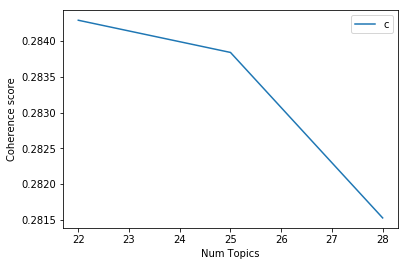

In [29]:
coherence_values = []
model_list = []

## Define test range of k values
start_k = 22 
max_k   = 29
step    = 3

## Run multiple models to test best coherence values

for num_of_topics in range(start_k, max_k, step):
    
    print("Checking model coherence for k = ", num_of_topics)
    
    gensim_model = gensim.models.LdaModel(corpus=corp, id2word=id2word, num_topics = num_of_topics, 
                                      alpha='auto',eta='auto', iterations=400, eval_every=5, random_state=2019)
    model_list.append(gensim_model)
    coherencemodel = CoherenceModel(model=gensim_model, texts=documents, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    
# Show graph
import matplotlib.pyplot as plt

x = range(start_k, max_k, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## 4. Run the topic model

In [30]:
# using gensim implementation
gensim_model = gensim.models.LdaModel(corpus=corp, id2word=id2word, num_topics = 22, 
                                      alpha='auto',eta='auto', iterations=1000, eval_every=5, random_state=2019)

## 5. Create the visualization with LDAvis

In [31]:
vis = pyLDAvis.gensim.prepare(gensim_model, corp, id2word)

# save visualization
pyLDAvis.save_html(vis, "breitbart_topic_model.html")

print("Done...")

/mnt/local/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Done...
